<a href="https://colab.research.google.com/github/talgalper/Honours-2021/blob/main/epitope_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# For each allele, create a list of epitope start and end points
# Note that residues are numbered starting at 1.
def find_epitope_boundaries(df, threshold, epitope_length):
    epitope_mask = df['rank'] <= threshold
    # A slightly roundabout way of ensuring we cover the full length of the epitope
    # Extends each epitope to the right by the length of the full epitope (e.g. 9 residues)
    full_epitope_mask = np.zeros(epitope_mask.shape[0] + epitope_length)
    for i in range(epitope_length):
        full_epitope_mask[i:(i-epitope_length)] = np.logical_or(full_epitope_mask[i:(i-epitope_length)], epitope_mask)
    # Now we can find epitope boundaries
    boundaries = []
    start = None
    for i, epitope in enumerate(full_epitope_mask):
        if epitope and start is None:
            start = i
        elif not epitope and start is not None:
            # Boundary is [start, end) (i.e. not inclusive of end value)
            boundaries.append((start+1, i+1))
            start = None
    # Finally, add last epitope that may not have been captured within the loop
    if start is not None:
        boundaries.append((start+1, len(full_epitope_mask)+1))
    return boundaries

def add_epitopes_to_plot(ax, epitope_dict, color='darkblue', rounded=True, rec_height=0.3,
                         epitope_offset=0.2, padding=0.2):
    y_labels = sorted(epitope_dict.keys())
    for i, key in enumerate(y_labels):
        for epitope in epitope_dict[key]:
            start = epitope[0]
            end = epitope[1]
            if rounded:
                width = end - start - 1
                rectangle = mpatches.FancyBboxPatch((start, i - rec_height/2), width, rec_height, boxstyle=f"Round, pad={padding}", color=color)
            else:
                width = end - start - 1 + epitope_offset*2
                rectangle = plt.Rectangle((start - epitope_offset, i - rec_height/2), width, rec_height, color=color)
            ax.add_patch(rectangle)
    return ax


def add_epitope_summary_to_plot(ax, epitope_dict, protein_length, color='darkblue'):
    #offset by 1, will ignore zeroth entry
    epitope_counts = np.zeros(protein_length+1)
    y_labels = sorted(epitope_dict.keys())
    for i, key in enumerate(y_labels):
        for epitope in epitope_dict[key]:
            epitope_counts[epitope[0]:epitope[1]] += 1
    epitope_freq = epitope_counts / len(y_labels)
    ax.plot(np.arange(1, protein_length+1), epitope_freq[1:], color=color)
    return ax
            


def plot_epitopes(df, high_threshold=0.5, low_threshold=2.0, high_color='#1f77b4', low_color='skyblue', epitope_length=9,
                  figsize=(14, 8), tick_freq=5):
    '''Plot NetMHC epitopes for multiple alleles.
    
    Args:
        df (pandas.DataFrame): A tidy DataFrame with columns 'allele', 'rank', and 'Position'
        high_threshold (float): Rank threshold for identifying high-binding epitopes
        low_threshold (float): Rank threshold for identifying low-binding epitopes
        high_color (str): A matplotlib color string coloring high-binding epitopes
        low_color (str): A matplotlib color string coloring low-binding epitopes
        epitope_length (int): Length of epitope in predictor
        figsize (tuple): Figure size
        tick_freq (int): Frequency of x-axis ticks
    Returns:
        matplotlib.Figure, [matplotlib.Axis, matplotlib.Axis]: Matplotlib figure and axes objects.
    '''
    seq_length = df.Position.max() + epitope_length + 1       # Offset by 1 so that residue numbering starts at 1.
    epitope_dict_high = {}

    for allele, sub_df in df.groupby('allele'):
        epitopes = find_epitope_boundaries(sub_df, high_threshold, epitope_length)
        epitope_dict_high[allele] = epitopes

    epitope_dict_low = {}

    for allele, sub_df in df.groupby('allele'):
        epitopes = find_epitope_boundaries(sub_df, low_threshold, epitope_length)
        epitope_dict_low[allele] = epitopes

    y_labels = sorted(epitope_dict_high.keys())
    fig = plt.figure(constrained_layout=False, figsize=figsize)
    gs = fig.add_gridspec(4, 1, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs[1:])
    ax1 = fig.add_subplot(gs[0], sharex=ax2)
    ax = ax2
    add_epitopes_to_plot(ax, epitope_dict_low, color=low_color)
    add_epitopes_to_plot(ax, epitope_dict_high, color=high_color)
    ax.set_ylim((-1, len(epitope_dict_high)))
    ax.set_xlim((0, seq_length))
    ax.xaxis.set_ticks(np.arange(tick_freq, seq_length, tick_freq))
    ax.yaxis.set_ticks(np.arange(0, len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=15)
    ax.set_ylabel("Allele", fontsize=25, labelpad=20)
    ax.set_xlabel("Residue Number", fontsize=25, labelpad=20)
    ax.tick_params(axis='x', labelsize=18)

# Creates red line to indicate points of interest. Insert aa no. into POI = [#]
    POI = [614, 484, 681, 501, 144, 452, 69, 70]
    for x in POI:
        point1 = [x, -1]
        point2 = [x, 12]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        ax.plot(x_values, y_values, color='red', alpha=0.5)

    ax = ax1
    add_epitope_summary_to_plot(ax, epitope_dict_high, seq_length, color=high_color)
    add_epitope_summary_to_plot(ax, epitope_dict_low, seq_length, color=low_color)
    ax.axis('off')

    return fig, [ax1, ax2]


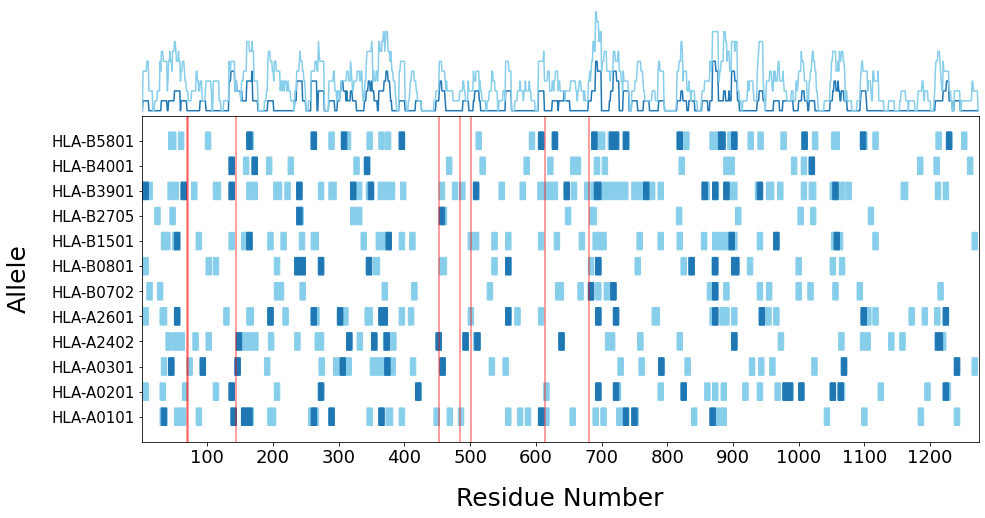

In [90]:
# Have to read data in and convert to tidy format
data = pd.read_csv('NetMHC_SWISS-MODEL.csv')

tidy_data = data.melt(id_vars=['Position'], var_name='allele', value_name='rank')

# Example plotting
fig, axes = plot_epitopes(tidy_data, tick_freq=100, figsize=(15, 8))

In [91]:
# Can then save figure in desired format.
fig.savefig('epitope_chart.png', bbox_inches='tight', facecolor='white')